In [1]:
import numpy as np
import pandas as pd
import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from pprint import pprint
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.
/home/rodrigo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rodrigo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rodrigo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rodrigo/.local/lib/python3.6/site-packages/tensorflow/py

In [2]:
# Importing data
data_csv = "wind_1.csv"
dataframe = pd.read_csv(data_csv, header=None)
wind_april = dataframe.values

data_csv = "wind_2.csv"
dataframe = pd.read_csv(data_csv, header=None)
wind_may = dataframe.values


 Lags analysed      :[0, 1, 2, 3, 4, 5, 17, 150]
 Linear correlation :[1.         0.96151483 0.93217717 0.91101969 0.89143141 0.87493881
 0.72735924 0.24894438]


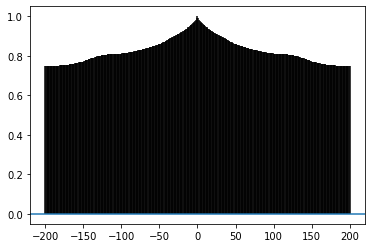

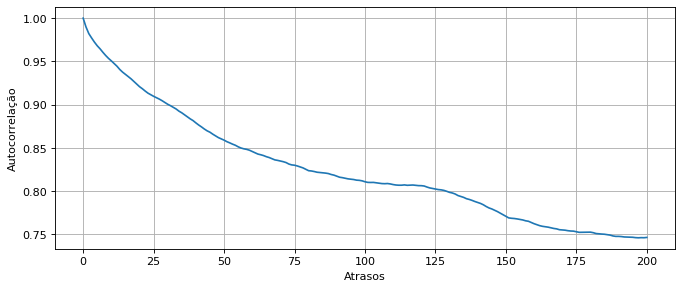

In [3]:
# Check the autocorrelation
# Get the linear correlation coefficient to check which lags to use
# Generating the autocorrelation to each Lags
wind_april = np.array(wind_april).flatten()
wind_may   = np.array(wind_may).flatten()
Lags = [0, 1, 2, 3, 4, 5, 17, 150]
start = Lags[-1]
end = len(wind_april)

# Lag matrix
lag_matrix = [wind_april[start - i : end - i] for i in Lags]
linear_corr = np.corrcoef(lag_matrix, lag_matrix)[0][:len(Lags)]
print(" Lags analysed      :{0}".format(Lags))
print(" Linear correlation :{0}".format(linear_corr))

ax = plt.xcorr(wind_april,wind_april, maxlags=200)

plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
lags = ax[0][200:]
corr = ax[1][200:]
plt.plot(lags,corr)
plt.ylabel('Autocorrelação')
plt.xlabel('Atrasos')
plt.grid(True)
plt.show()

In [4]:
# Split the dataset in train, validation and test
# Split the dataset
Lags = np.arange(1,125)
start = Lags[-1]
end = 4320
x_train = [wind_april[start - i : end - i] for i in Lags]
y_train = wind_april[start:end]

start = Lags[-1]
end = 2200
x_val = [wind_may[start - i : end - i] for i in Lags]
y_val = wind_may[start:end]

start = 2201
end = 4460
x_test = [wind_may[start - i : end - i] for i in Lags]
y_test = wind_may[start:end]


In [5]:
class_1  = [len(wind_april),0,0,len(wind_april)]
class_2  = [0,2200,4460-2201,len(wind_may)]
n_data = len(wind_april) + len(wind_may)
total    = [len(wind_april),2200,4460-2201,n_data]
porcentagem = [len(wind_april)*100/n_data,2200*100/n_data,(4460-2201)*100/n_data,100]
table_df = {'Lote de dados': ['Treino','Validação','Teste','Total'],'Porcentagem':porcentagem, 'Abril': class_1,'Maio': class_2,'Total':total}
table_df = pd.DataFrame(data=table_df)
table_df.to_csv('divisao_de_dados')
table_df

,Lote de dados,Porcentagem,Abril,Maio,Total
0,Treino,49.202733,4320,0,4320
1,Validação,25.056948,0,2200,2200
2,Teste,25.728929,0,2259,2259
3,Total,100.000000,4320,4460,8780


In [6]:
# Normalize the datasets
min1 = np.min(x_train[0])
mawind_may = np.max(x_train[0])
min2 = np.min(x_train[1])
max2 = np.max(x_train[1])
x_train[0] = (x_train[0] - min1) / (mawind_may - min1)
x_train[1] = (x_train[1] - min2) / (mawind_may - min2)

min1 = np.min(x_val[0])
mawind_may = np.max(x_val[0])
min2 = np.min(x_val[1])
max2 = np.max(x_val[1])
x_val[0] = (x_val[0] - min1) / (mawind_may - min1)
x_val[1] = (x_val[1] - min2) / (mawind_may - min2)

min1 = np.min(x_test[0])
mawind_may = np.max(x_test[0])
min2 = np.min(x_test[1])
max2 = np.max(x_test[1])
x_test[0] = (x_test[0] - min1) / (mawind_may - min1)
x_test[1] = (x_test[1] - min2) / (mawind_may - min2)

x_test = np.transpose(x_test)
x_train = np.transpose(x_train)
x_val = np.transpose(x_val)

y_test = np.transpose(y_test)
y_train = np.transpose(y_train)
y_val = np.transpose(y_val)


In [42]:
# Building the NN
lr = 0.001  # learning rate
lr_decay = 0.0005# learning rate decay
n_mini_batch = 100  # mini-batch length
activation_fcn = "sigmoid"
optimizer = Adam(lr=lr, decay=lr_decay)
input_dim = x_train.shape[1]
h_n = 30
model = Sequential()
model.add(Dense(h_n, input_dim=input_dim, activation=activation_fcn))
model.add(Dense(1, activation="linear"))

# Compile model
model.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])

# Train and validate the model
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=50,
    # verbose=0,
    callbacks=[
        EarlyStopping(
            monitor="val_loss", mode="min", min_delta=1, patience=20, verbose=1
        )
    ],
)

Train on 4196 samples, validate on 2076 samples
Epoch 1/200
4196/4196 [==============================] - 1s 259us/step - loss: 5.9325 - acc: 9.5329e-04 - val_loss: 5.3620 - val_acc: 0.0014
Epoch 2/200
4196/4196 [==============================] - 0s 55us/step - loss: 4.2231 - acc: 0.0033 - val_loss: 4.4826 - val_acc: 9.6339e-04
Epoch 3/200
4196/4196 [==============================] - 0s 55us/step - loss: 3.5610 - acc: 0.0026 - val_loss: 3.6358 - val_acc: 4.8170e-04
Epoch 4/200
4196/4196 [==============================] - 0s 56us/step - loss: 3.1076 - acc: 0.0041 - val_loss: 3.2368 - val_acc: 9.6339e-04
Epoch 5/200
4196/4196 [==============================] - 0s 55us/step - loss: 2.7936 - acc: 0.0045 - val_loss: 3.1936 - val_acc: 0.0019
Epoch 6/200
4196/4196 [==============================] - 0s 56us/step - loss: 2.5137 - acc: 0.0041 - val_loss: 2.6214 - val_acc: 4.8170e-04
Epoch 7/200
4196/4196 [==============================] - 0s 57us/step - loss: 2.2962 - acc: 0.0060 - val_loss: 2.41

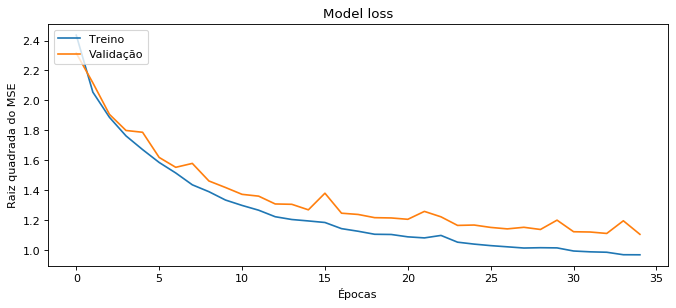

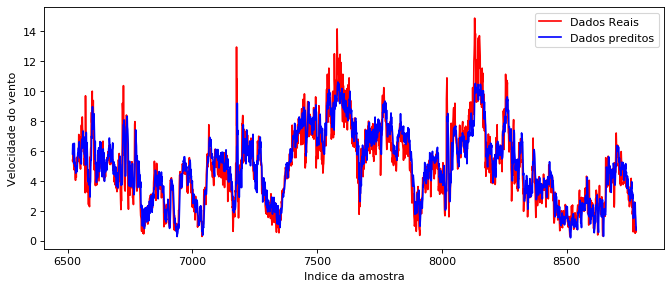

In [44]:
# Plot the validation and train loss
plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.sqrt(history.history["loss"]))
plt.plot(np.sqrt(history.history["val_loss"]))
plt.title("Model loss")
plt.ylabel("Raiz quadrada do MSE")
plt.xlabel("Épocas")
plt.legend(["Treino", "Validação"], loc="upper left")
plt.show()

pred = model.predict(x_test)
pred = np.array(pred).flatten()

plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(np.arange(len(wind_april)+2200,len(wind_april)+len(wind_may)-1),y_test.flatten(), 'r',label='Dados Reais')
plt.plot(np.arange(len(wind_april)+2200,len(wind_april)+len(wind_may)-1),pred.flatten(), 'b',label="Dados preditos")
plt.legend()
plt.ylabel('Velocidade do vento')
plt.xlabel('Indice da amostra')
plt.show()


In [18]:
neurons = [5,10,15,30]
repetitions = 2
result = list()
for neuron in neurons:
    result_i = list()
    for i in range(0,repetitions):
        lr = 0.001  # learning rate
        lr_decay = 0.0005# learning rate decay
        n_mini_batch = 50  # mini-batch length
        activation_fcn = "sigmoid"
        optimizer = Adam(lr=lr, decay=lr_decay)
        input_dim = x_train.shape[1]
        h_n = neuron
        model = Sequential()
        model.add(Dense(h_n, input_dim=input_dim, activation=activation_fcn))
        model.add(Dense(1, activation="linear"))

        # Compile model
        model.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])

        # Train and validate the model
        history = model.fit(
            x_train,
            y_train,
            validation_data=(x_val, y_val),
            epochs=200,
            batch_size=n_mini_batch,
            # verbose=0,
            callbacks=[
                EarlyStopping(
                    monitor="val_loss", mode="min", min_delta=1, patience=10, verbose=1
                )
            ],
        )
        pred = model.predict(x_test)
        pred = np.array(pred).flatten()
        error = mean_squared_error(y_test,pred)
        result_i.append(error)
    result.append(result_i)

Train on 4196 samples, validate on 2076 samples
Epoch 1/200
4196/4196 [==============================] - 1s 201us/step - loss: 16.6407 - acc: 0.0017 - val_loss: 20.3381 - val_acc: 0.0029
Epoch 2/200
4196/4196 [==============================] - 0s 49us/step - loss: 14.1979 - acc: 0.0033 - val_loss: 18.3028 - val_acc: 0.0029
Epoch 3/200
4196/4196 [==============================] - 0s 51us/step - loss: 12.7542 - acc: 0.0033 - val_loss: 16.5833 - val_acc: 0.0029
Epoch 4/200
4196/4196 [==============================] - 0s 52us/step - loss: 11.5693 - acc: 0.0033 - val_loss: 15.1281 - val_acc: 0.0029
Epoch 5/200
4196/4196 [==============================] - 0s 51us/step - loss: 10.5996 - acc: 0.0083 - val_loss: 13.9109 - val_acc: 0.0029
Epoch 6/200
4196/4196 [==============================] - 0s 52us/step - loss: 9.8099 - acc: 0.0098 - val_loss: 12.8900 - val_acc: 0.0029
Epoch 7/200
4196/4196 [==============================] - 0s 51us/step - loss: 9.1697 - acc: 0.0098 - val_loss: 12.0222 - val

4196/4196 [==============================] - 0s 40us/step - loss: 3.4301 - acc: 0.0029 - val_loss: 3.7572 - val_acc: 0.0019
Epoch 16/200
4196/4196 [==============================] - 0s 44us/step - loss: 3.2878 - acc: 0.0026 - val_loss: 3.9993 - val_acc: 0.0034
Epoch 17/200
4196/4196 [==============================] - 0s 40us/step - loss: 3.1683 - acc: 0.0031 - val_loss: 3.4647 - val_acc: 0.0019
Epoch 18/200
4196/4196 [==============================] - 0s 41us/step - loss: 3.0586 - acc: 0.0031 - val_loss: 3.4024 - val_acc: 0.0029
Epoch 19/200
4196/4196 [==============================] - 0s 43us/step - loss: 2.9575 - acc: 0.0036 - val_loss: 3.1980 - val_acc: 0.0014
Epoch 20/200
4196/4196 [==============================] - 0s 40us/step - loss: 2.8410 - acc: 0.0036 - val_loss: 3.2160 - val_acc: 0.0029
Epoch 21/200
4196/4196 [==============================] - 0s 41us/step - loss: 2.7448 - acc: 0.0045 - val_loss: 3.0075 - val_acc: 0.0029
Epoch 22/200
4196/4196 [==============================

4196/4196 [==============================] - 0s 92us/step - loss: 4.2183 - acc: 0.0055 - val_loss: 5.1724 - val_acc: 0.0019
Epoch 13/200
4196/4196 [==============================] - 0s 90us/step - loss: 3.9891 - acc: 0.0045 - val_loss: 4.7863 - val_acc: 0.0024
Epoch 14/200
4196/4196 [==============================] - 0s 84us/step - loss: 3.7682 - acc: 0.0055 - val_loss: 4.4502 - val_acc: 0.0014
Epoch 15/200
4196/4196 [==============================] - 0s 93us/step - loss: 3.6126 - acc: 0.0052 - val_loss: 4.3233 - val_acc: 0.0014
Epoch 16/200
4196/4196 [==============================] - 0s 85us/step - loss: 3.4144 - acc: 0.0060 - val_loss: 3.9634 - val_acc: 9.6339e-04
Epoch 17/200
4196/4196 [==============================] - 0s 82us/step - loss: 3.2660 - acc: 0.0062 - val_loss: 3.7726 - val_acc: 0.0019
Epoch 18/200
4196/4196 [==============================] - 0s 89us/step - loss: 3.1304 - acc: 0.0050 - val_loss: 3.6638 - val_acc: 0.0029
Epoch 19/200
4196/4196 [==========================

4196/4196 [==============================] - 0s 81us/step - loss: 2.8917 - acc: 0.0069 - val_loss: 3.3159 - val_acc: 9.6339e-04
Epoch 18/200
4196/4196 [==============================] - 0s 53us/step - loss: 2.7574 - acc: 0.0055 - val_loss: 3.1169 - val_acc: 4.8170e-04
Epoch 19/200
4196/4196 [==============================] - 0s 50us/step - loss: 2.6226 - acc: 0.0062 - val_loss: 2.9422 - val_acc: 4.8170e-04
Epoch 20/200
4196/4196 [==============================] - 0s 52us/step - loss: 2.5009 - acc: 0.0069 - val_loss: 2.8497 - val_acc: 0.0019
Epoch 21/200
4196/4196 [==============================] - 0s 52us/step - loss: 2.3846 - acc: 0.0067 - val_loss: 2.6860 - val_acc: 9.6339e-04
Epoch 22/200
4196/4196 [==============================] - 0s 51us/step - loss: 2.2835 - acc: 0.0064 - val_loss: 2.6294 - val_acc: 4.8170e-04
Epoch 23/200
4196/4196 [==============================] - 0s 51us/step - loss: 2.2197 - acc: 0.0079 - val_loss: 2.5833 - val_acc: 0.0029
Epoch 24/200
4196/4196 [==========

4196/4196 [==============================] - 0s 52us/step - loss: 1.4711 - acc: 0.0081 - val_loss: 1.8027 - val_acc: 0.0029
Epoch 18/200
4196/4196 [==============================] - 0s 53us/step - loss: 1.3769 - acc: 0.0076 - val_loss: 1.6385 - val_acc: 0.0034
Epoch 19/200
4196/4196 [==============================] - 0s 50us/step - loss: 1.3606 - acc: 0.0074 - val_loss: 1.6655 - val_acc: 0.0024
Epoch 20/200
4196/4196 [==============================] - 0s 53us/step - loss: 1.3115 - acc: 0.0086 - val_loss: 1.5181 - val_acc: 0.0029
Epoch 00020: early stopping


In [19]:
result = np.array(result).reshape((len(neurons),repetitions))

In [34]:
mean = [np.mean(i) for i in result]
acc  = np.array(result) 
mean_acc = np.array(mean)

result_dict = {'neurons': neurons, 'results_1': result[:,0],'results_2':result[:,1], 'mean': mean, 'MSE1' : acc[:,0],'MSE2' : acc[:,1] , 'mean_mse': mean_acc}
result_df = pd.DataFrame(data=result_dict)
result_df.to_csv('results.csv')
result_df


,neurons,results_1,results_2,mean,MSE1,MSE2,mean_mse
0,5,2.529916,2.115913,2.322915,2.529916,2.115913,2.322915
1,10,1.901165,2.016710,1.958937,1.901165,2.016710,1.958937
2,15,1.731233,1.686487,1.708860,1.731233,1.686487,1.708860
3,30,1.686144,1.538253,1.612198,1.686144,1.538253,1.612198


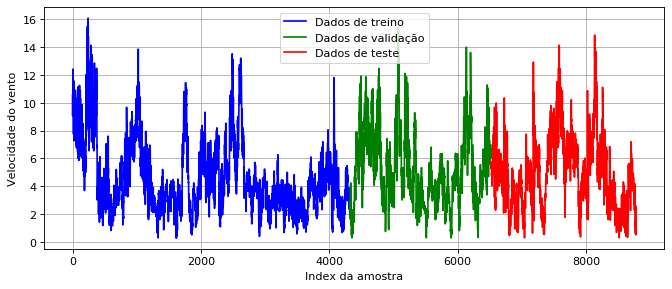

In [33]:
plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(wind_april,'b',label='Dados de treino')
plt.plot(np.arange(len(wind_april),len(wind_april)+2200),wind_may[:2200],'g',label='Dados de validação')
plt.plot(np.arange(len(wind_april)+2200,len(wind_april)+len(wind_may)),wind_may[2200:],'r',label='Dados de teste')
plt.ylabel('Velocidade do vento')
plt.xlabel('Index da amostra')
plt.legend()
plt.grid(True)
plt.show()